# Final Analysis: IMDb and Financial Data Integration

## Business Understanding

### Objective
This project analyzes the intersection of audience preferences (IMDb ratings) and financial performance (budgets and revenue) to derive actionable insights for movie studios. By merging IMDb data with TMDb and budget datasets, we aim to:
- Identify the most profitable genres and their audience ratings.
- Correlate financial performance with popularity and ratings.
- Offer genre and studio strategies for maximum ROI.

### Data Sources
1. **IMDb Database**:
   - Contains movie ratings, genres, and key details.
2. **TMDb Dataset**:
   - Includes popularity metrics and genre encodings.
3. **Budget Dataset**:
   - Provides production budgets, domestic, and worldwide revenue.



## CRISP-DM Framework

1. **Business Understanding**: Define the objectives and questions.
2. **Data Understanding**: Explore the datasets to understand their structure and content.
3. **Data Preparation**: Clean, transform, and merge data for analysis.
4. **Modeling/Analysis**: Uncover trends and correlations through visualizations and metrics.
5. **Evaluation**: Summarize key findings and actionable insights.
6. **Deployment**: Present the final results in a structured manner.

### Let's begin with data understanding and preparation.


## Data Understanding

We work with the following datasets:
- **IMDb Database**: Contains movie ratings and genres.
- **TMDb Data**: Offers genre encodings, popularity scores, and audience ratings.
- **Budget Data**: Includes production budgets, domestic, and worldwide revenue.

The datasets will be merged using movie titles and release years.

## Data Preparation

### Steps:
1. Clean and format financial and popularity data (TMDb and budget datasets).
2. Extract relevant information from the IMDb database (`movie_basics` and `movie_ratings`).
3. Merge all datasets on movie titles and release years for a unified analysis base.

### Code Implementation:


In [1]:
#install all libraries to be used
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style('whitegrid')
import scipy as sp
import scipy.stats as st
import sqlite3
from zipfile import ZipFile
import os
import statsmodels.api as sm
from matplotlib.colors import ListedColormap
from statsmodels.stats.power import TTestIndPower, TTestPower
import statsmodels.formula as smf
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Load financial datasets
tmdb_movies_path = "C:\\Projects\\group3-phase2-project\\data\\tmdb.movies.csv"
movie_budgets_path = "C:\\Projects\\group3-phase2-project\\data\\tn.movie_budgets.csv"

df_tmdb_movies = pd.read_csv(tmdb_movies_path, encoding='latin1')
df_movie_budgets = pd.read_csv(movie_budgets_path, encoding='latin1')

In [6]:
# Clean financial data
def clean_currency(column):
    return column.replace({'\$': '', ',': ''}, regex=True).astype(float)

df_movie_budgets['production_budget'] = clean_currency(df_movie_budgets['production_budget'])
df_movie_budgets['domestic_gross'] = clean_currency(df_movie_budgets['domestic_gross'])
df_movie_budgets['worldwide_gross'] = clean_currency(df_movie_budgets['worldwide_gross'])


In [7]:
# Standardize release_date
df_movie_budgets['release_date'] = pd.to_datetime(df_movie_budgets['release_date'], errors='coerce')
df_tmdb_movies['release_date'] = pd.to_datetime(df_tmdb_movies['release_date'], errors='coerce')

In [8]:
# Extract release year
df_movie_budgets['release_year'] = df_movie_budgets['release_date'].dt.year
df_tmdb_movies['release_year'] = df_tmdb_movies['release_date'].dt.year

In [9]:
# Merge TMDb and budget datasets
merged_df = pd.merge(
    df_tmdb_movies,
    df_movie_budgets,
    how='inner',
    left_on=['title', 'release_year'],
    right_on=['movie', 'release_year']
)


In [14]:
import zipfile
import os

# Define paths
imdb_db_path = r"C:\Projects\group3-phase2-project\data\im.db.zip"
extracted_dir = r"C:\Projects\group3-phase2-project\data\extracted"

# Create the directory if it does not exist
os.makedirs(extracted_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extracted_dir)

print("Extraction completed.")


Extraction completed.


In [18]:
# Define the database path
imdb_db_path = r"C:\Projects\group3-phase2-project\data\extracted\im.db"

# Connect to the database
conn = sqlite3.connect(imdb_db_path)

# Test the connection
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:", tables)

# Query data from the tables
movie_basics_query = "SELECT * FROM movie_basics;"
movie_ratings_query = "SELECT * FROM movie_ratings;"

movie_basics = pd.read_sql_query(movie_basics_query, conn)[['movie_id', 'primary_title', 'start_year', 'genres']]
movie_ratings = pd.read_sql_query(movie_ratings_query, conn)

# Preview the data
print(movie_basics.head())
print(movie_ratings.head())


Tables in the database: [('movie_basics',), ('directors',), ('known_for',), ('movie_akas',), ('movie_ratings',), ('persons',), ('principals',), ('writers',)]
    movie_id                    primary_title  start_year  \
0  tt0063540                        Sunghursh        2013   
1  tt0066787  One Day Before the Rainy Season        2019   
2  tt0069049       The Other Side of the Wind        2018   
3  tt0069204                  Sabse Bada Sukh        2018   
4  tt0100275         The Wandering Soap Opera        2017   

                 genres  
0    Action,Crime,Drama  
1       Biography,Drama  
2                 Drama  
3          Comedy,Drama  
4  Comedy,Drama,Fantasy  
     movie_id  averagerating  numvotes
0  tt10356526            8.3        31
1  tt10384606            8.9       559
2   tt1042974            6.4        20
3   tt1043726            4.2     50352
4   tt1060240            6.5        21


In [19]:
# Rename and merge IMDb data
movie_basics = movie_basics.rename(columns={'primary_title': 'title', 'start_year': 'release_year', 'genres': 'imdb_genres'})
imdb_merged = pd.merge(movie_basics, movie_ratings, on='movie_id', how='inner')

In [20]:
final_merged_df = pd.merge(
    merged_df,
    imdb_merged,
    how='inner',
    left_on=['title', 'release_year'],
    right_on=['title', 'release_year']
)

In [21]:
# Add metrics
final_merged_df['profitability'] = final_merged_df['worldwide_gross'] - final_merged_df['production_budget']
final_merged_df['ROI'] = (final_merged_df['worldwide_gross'] - final_merged_df['production_budget']) / final_merged_df['production_budget']

final_merged_df.head()

,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,title,vote_average,vote_count,...,movie,production_budget,domestic_gross,worldwide_gross,movie_id,imdb_genres,averagerating,numvotes,profitability,ROI
0,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,...,How to Train Your Dragon,165000000.0,217581232.0,4.948710e+08,tt0892769,"Action,Adventure,Animation",8.1,611299,329870992.0,1.999218
1,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,...,Iron Man 2,170000000.0,312433331.0,6.211564e+08,tt1228705,"Action,Adventure,Sci-Fi",7.0,657690,451156389.0,2.653861
2,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,...,Inception,160000000.0,292576195.0,8.355246e+08,tt1375666,"Action,Adventure,Sci-Fi",8.8,1841066,675524642.0,4.222029
3,5,"[12, 14, 10751]",32657,en,Percy Jackson & the Olympians: The Lightning T...,26.691,2010-02-11,Percy Jackson & the Olympians: The Lightning T...,6.1,4229,...,Percy Jackson & the Olympians: The Lightning T...,95000000.0,88768303.0,2.230509e+08,tt0814255,"Adventure,Family,Fantasy",5.9,165108,128050874.0,1.347904
4,7,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340,...,Toy Story 3,200000000.0,415004880.0,1.068880e+09,tt0435761,"Adventure,Animation,Comedy",8.3,682218,868879522.0,4.344398


## Exploratory Data Analysis (EDA)

### Objectives:
1. Validate the completeness and integrity of the merged dataset.
2. Analyze and visualize key metrics:
   - Financial metrics: Profitability, ROI.
   - Audience metrics: Ratings, vote counts.
3. Investigate genre-based trends and correlations.



In [22]:
# Validate dataset structure
print("Dataset Shape:", final_merged_df.shape)
print("Dataset Columns:", final_merged_df.columns)

Dataset Shape: (1513, 23)
Dataset Columns: Index(['Unnamed: 0', 'genre_ids', 'id_x', 'original_language',
       'original_title', 'popularity', 'release_date_x', 'title',
       'vote_average', 'vote_count', 'release_year', 'id_y', 'release_date_y',
       'movie', 'production_budget', 'domestic_gross', 'worldwide_gross',
       'movie_id', 'imdb_genres', 'averagerating', 'numvotes', 'profitability',
       'ROI'],
      dtype='object')


In [23]:
# Check for missing values
missing_values = final_merged_df.isnull().sum()
print("Missing Values:\n", missing_values)


Missing Values:
 Unnamed: 0           0
genre_ids            0
id_x                 0
original_language    0
original_title       0
popularity           0
release_date_x       0
title                0
vote_average         0
vote_count           0
release_year         0
id_y                 0
release_date_y       0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
movie_id             0
imdb_genres          2
averagerating        0
numvotes             0
profitability        0
ROI                  0
dtype: int64


In [24]:
# Check the rows with missing imdb_genres
missing_genres = final_merged_df[final_merged_df['imdb_genres'].isnull()]
print("Rows with Missing imdb_genres:\n", missing_genres)

# Replace missing values in imdb_genres with 'Unknown'
final_merged_df['imdb_genres'].fillna('Unknown', inplace=True)

# Confirm that no missing values remain
print("Missing Values After Imputation:\n", final_merged_df.isnull().sum())


Rows with Missing imdb_genres:
       Unnamed: 0     genre_ids    id_x original_language     original_title  \
83           140  [28, 35, 18]   27573                en  The Bounty Hunter   
1402       23822  [12, 28, 53]  375588                en         Robin Hood   

      popularity release_date_x              title  vote_average  vote_count  \
83         9.861     2010-03-19  The Bounty Hunter           5.7        1627   
1402      39.975     2018-11-21         Robin Hood           5.8        1194   

      ...              movie  production_budget domestic_gross  \
83    ...  The Bounty Hunter         45000000.0     67061228.0   
1402  ...         Robin Hood         99000000.0     30824628.0   

     worldwide_gross   movie_id  imdb_genres  averagerating numvotes  \
83       135808837.0  tt1472211         None            6.3       29   
1402      84747441.0  tt6858500         None            7.6        5   

     profitability       ROI  
83      90808837.0  2.017974  
1402   -142

In [25]:
# Check for missing values
missing_values = final_merged_df.isnull().sum()
print("Missing Values:\n", missing_values)


Missing Values:
 Unnamed: 0           0
genre_ids            0
id_x                 0
original_language    0
original_title       0
popularity           0
release_date_x       0
title                0
vote_average         0
vote_count           0
release_year         0
id_y                 0
release_date_y       0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
movie_id             0
imdb_genres          0
averagerating        0
numvotes             0
profitability        0
ROI                  0
dtype: int64


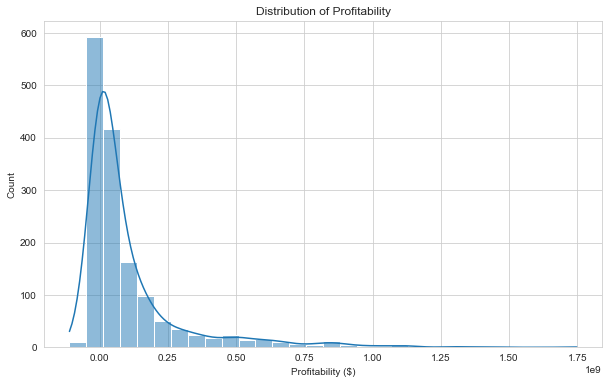

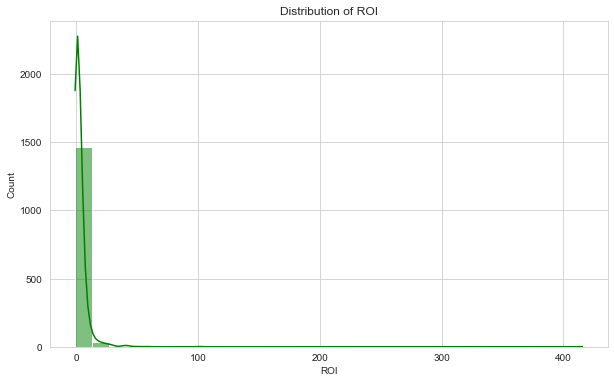

In [26]:
# Distribution of financial metrics (Profitability and ROI)
plt.figure(figsize=(10, 6))
sns.histplot(final_merged_df['profitability'], bins=30, kde=True)
plt.title('Distribution of Profitability')
plt.xlabel('Profitability ($)')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(final_merged_df['ROI'], bins=30, kde=True, color='green')
plt.title('Distribution of ROI')
plt.xlabel('ROI')
plt.show()

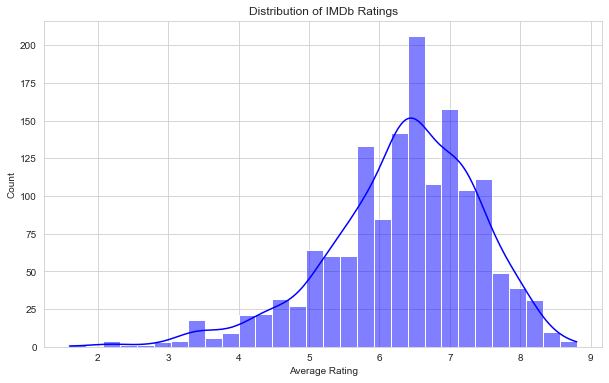

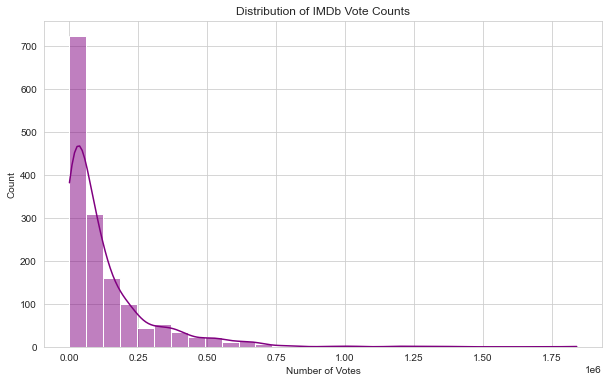

In [27]:
# Distribution of audience metrics (Ratings and Vote Counts)
plt.figure(figsize=(10, 6))
sns.histplot(final_merged_df['averagerating'], bins=30, kde=True, color='blue')
plt.title('Distribution of IMDb Ratings')
plt.xlabel('Average Rating')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(final_merged_df['numvotes'], bins=30, kde=True, color='purple')
plt.title('Distribution of IMDb Vote Counts')
plt.xlabel('Number of Votes')
plt.show()

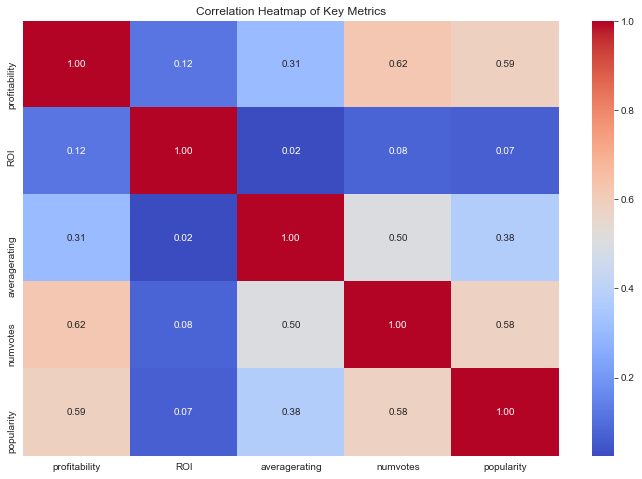

In [28]:
# Correlation heatmap for numerical features
plt.figure(figsize=(12, 8))
correlation_matrix = final_merged_df[['profitability', 'ROI', 'averagerating', 'numvotes', 'popularity']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Key Metrics')
plt.show()


In [31]:
# Split IMDb genres into lists if they are comma-separated
final_merged_df['decoded_genres'] = final_merged_df['imdb_genres'].str.split(',')


In [32]:
# Genre-level analysis
genre_financials = final_merged_df.explode('decoded_genres').groupby('decoded_genres').agg({
    'profitability': 'mean',
    'ROI': 'mean',
    'averagerating': 'mean',
    'numvotes': 'mean'
}).sort_values('profitability', ascending=False)

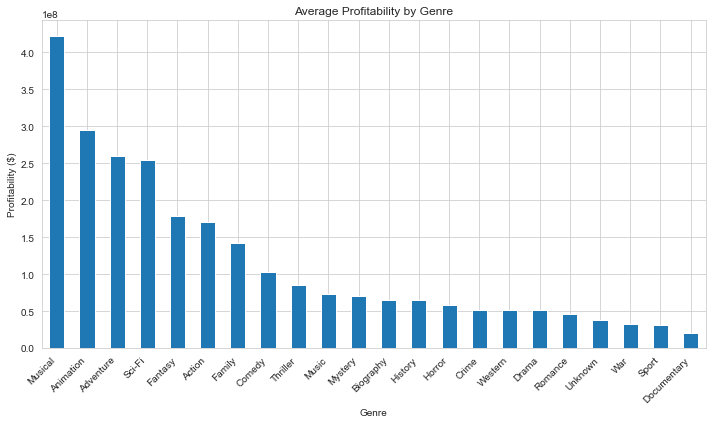

In [33]:
# Profitability by Genre
plt.figure(figsize=(10, 6))
genre_financials['profitability'].plot(kind='bar', title='Average Profitability by Genre', ylabel='Profitability ($)', xlabel='Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

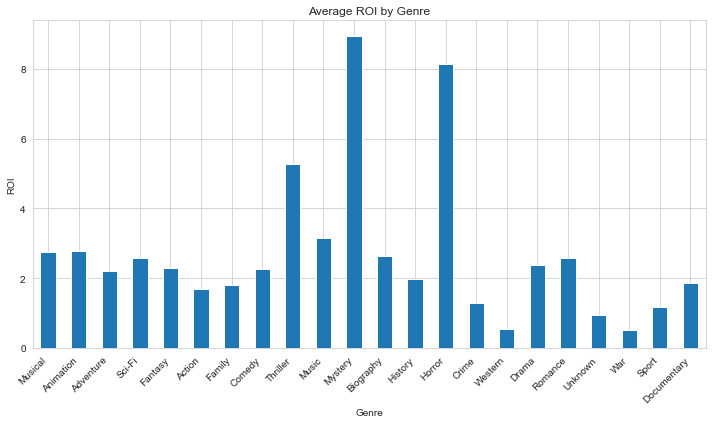

In [34]:
# ROI by Genre
plt.figure(figsize=(10, 6))
genre_financials['ROI'].plot(kind='bar', title='Average ROI by Genre', ylabel='ROI', xlabel='Genre')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [36]:
# Display genre-level insights
print(genre_financials)


                profitability       ROI  averagerating       numvotes
decoded_genres                                                       
Musical          4.221287e+08  2.743062       6.375000   97406.500000
Animation        2.946932e+08  2.779845       6.641346  132345.336538
Adventure        2.604154e+08  2.214809       6.483240  212069.617318
Sci-Fi           2.542866e+08  2.592440       6.486029  283766.713235
Fantasy          1.794084e+08  2.305333       6.188800  161787.656000
Action           1.711074e+08  1.705806       6.283073  186938.951002
Family           1.429225e+08  1.795499       6.094792   84598.854167
Comedy           1.023735e+08  2.259551       6.246443   97479.561265
Thriller         8.496777e+07  5.284178       6.044776  122625.347015
Music            7.269438e+07  3.152081       6.328889   83080.777778
Mystery          7.047321e+07  8.938880       6.183465  138140.393701
Biography        6.540502e+07  2.647974       7.087755  125528.414966
History          6.4

In [38]:
genre_financials.to_csv("genre_financials_insights.csv", index=True)
print("Genre insights saved to 'genre_financials_insights.csv'")


Genre insights saved to 'genre_financials_insights.csv'


In [42]:
numeric_columns = ['profitability', 'ROI', 'averagerating', 'numvotes', 'popularity']
numeric_stats = final_merged_df[numeric_columns].describe()

print("Descriptive Statistics for Selected Columns:\n", numeric_stats)



Descriptive Statistics for Selected Columns:
        profitability          ROI  averagerating      numvotes   popularity
count   1.513000e+03  1513.000000    1513.000000  1.513000e+03  1513.000000
mean    1.057039e+08     2.860562       6.343358  1.245225e+05    13.064105
std     1.994867e+08    12.034195       1.070645  1.664209e+05     8.182363
min    -1.104502e+08    -1.000000       1.600000  5.000000e+00     0.600000
25%    -3.000000e+05    -0.128115       5.800000  1.855200e+04     8.261000
50%     2.852765e+07     1.254640       6.400000  6.908100e+04    11.458000
75%     1.191555e+08     3.115395       7.100000  1.591110e+05    16.190000
max     1.748134e+09   415.564740       8.800000  1.841066e+06    80.773000


In [43]:
print("Genre-Level Financial and Audience Insights:")
print(genre_financials.head())  # Display the top rows for a preview


Genre-Level Financial and Audience Insights:
                profitability       ROI  averagerating       numvotes
decoded_genres                                                       
Musical          4.221287e+08  2.743062       6.375000   97406.500000
Animation        2.946932e+08  2.779845       6.641346  132345.336538
Adventure        2.604154e+08  2.214809       6.483240  212069.617318
Sci-Fi           2.542866e+08  2.592440       6.486029  283766.713235
Fantasy          1.794084e+08  2.305333       6.188800  161787.656000
